# Clustering using numerical and categorical data : K-Prototypes

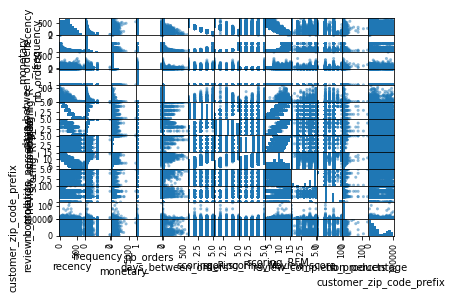

In [8]:
import pandas as pd
import numpy as np
import os
import sys
from kmodes.kprototypes import KPrototypes
from sklearn.model_selection import train_test_split

rfmsppl = pd.read_csv("./../../../output/rfmsppl.csv")

rfmsppl.drop(columns=["first_order", "last_order"], inplace=True)
y = rfmsppl["review_score"]

X_train, X_test, y_train, y_test = train_test_split(
    rfmsppl, y, test_size=0.2, random_state=42, stratify=y
)
rfmsppl = X_test

pd.plotting.scatter_matrix(rfmsppl);

## Variables transformation from numerical to categorical

And what if we consider the frequency as a category ?

* It can be interesting to consider single order customers to the others ones.
* Also, we could consider customers who contribute reviews (title, message) from the one who don't.
* As monetary is really skewed, we may introduce bins.

Let's try this and see if we can have a better clustering after that !

In [9]:
rfmsppl

recency  frequency  monetary  nb_orders  days_between_orders  \
86359    147.0   0.166667    143.56        1.0                    0   
42247    174.0   0.142857    159.03        1.0                    0   
70502    114.0   0.200000    701.66        1.0                    0   
1832     167.0   0.142857    184.56        1.0                    0   
18729    583.0   0.050000     91.07        1.0                    0   
...        ...        ...       ...        ...                  ...   
36084     67.0   0.333333     84.87        1.0                    0   
6        132.0   0.200000     35.38        1.0                    0   
50280    220.0   0.125000    116.85        1.0                    0   
6970     235.0   0.111111    464.05        1.0                    0   
53369     37.0   0.500000     29.22        1.0                    0   

       scoring_R  scoring_F  scoring_M  scoring_RFM        segment_RFM  \
86359          4          4          4           12       Bons clients   
42247          4          3          4           11       Bons clients   
70502          4          4          5           13  Très bons clients   
1832           4          3          4           11       Bons clients   
18729          1          1          3            5     Clients tièdes   
...          ...        ...        ...          ...                ...   
36084          5          5          2           12       Bons clients   
6              4          4          1            9       Bons clients   
50280          3          3          3            9       Bons clients   
6970           3          3          5           11       Bons clients   
53369          5          5          1           11       Bons clients   

       review_score  review_completion_percentage   review_behavior  \
86359           5.0                     33.333333  Best Contributor   
42247           3.0                     66.666667  Best Contributor   
70502           5.0                    100.000000  Best Contributor   
1832            1.0                     66.666667  Best Contributor   
18729           4.0                     66.666667  Best Contributor   
...             ...                           ...               ...   
36084           5.0                     66.666667  Best Contributor   
6               4.0                     33.333333  Best Contributor   
50280           5.0                     33.333333  Best Contributor   
6970            4.0                     33.333333  Best Contributor   
53369           4.0                     66.666667  Best Contributor   

       nb_products  customer_zip_code_prefix          customer_city  \
86359            3                      6315            carapicuiba   
42247            1                      7841        franco da rocha   
70502            1                     18045               sorocaba   
1832             1                     23071         rio de janeiro   
18729            1                     38735  cruzeiro da fortaleza   
...            ...                       ...                    ...   
36084            1                     66030                  belem   
6                1                     13084               campinas   
50280            1                     84200            jaguariaiva   
6970             1                     22750         rio de janeiro   
53369            1                     21920         rio de janeiro   

      customer_state  
86359             SP  
42247             SP  
70502             SP  
1832              RJ  
18729             MG  
...              ...  
36084             PA  
6                 SP  
50280             PR  
6970              RJ  
53369             RJ  

[18622 rows x 17 columns]

Let's plot the distribution of monetary :

In [10]:
rfmsppl.monetary.describe()

count    18622.000000
mean       164.639635
std        214.095173
min         13.780000
25%         63.600000
50%        107.850000
75%        183.287500
max       6929.310000
Name: monetary, dtype: float64

## Using K-Prototype clustering method

We have to evaluate the right number of clusters even if we are confident it's around **5** as stated by our previous experiments.

In [11]:
# Prepare variables for transformation and remove useless ones
transformed_customers = rfmsppl.copy()
transformed_customers = transformed_customers.drop(
    columns=["review_completion_percentage", "nb_orders"]
)
transformed_customers.loc[
    transformed_customers.review_score == 0, "review_score"
] = 1e-5

transformed_customers.head()

recency  frequency  monetary  days_between_orders  scoring_R  \
86359    147.0   0.166667    143.56                    0          4   
42247    174.0   0.142857    159.03                    0          4   
70502    114.0   0.200000    701.66                    0          4   
1832     167.0   0.142857    184.56                    0          4   
18729    583.0   0.050000     91.07                    0          1   

       scoring_F  scoring_M  scoring_RFM        segment_RFM  review_score  \
86359          4          4           12       Bons clients           5.0   
42247          3          4           11       Bons clients           3.0   
70502          4          5           13  Très bons clients           5.0   
1832           3          4           11       Bons clients           1.0   
18729          1          3            5     Clients tièdes           4.0   

        review_behavior  nb_products  customer_zip_code_prefix  \
86359  Best Contributor            3                      6315   
42247  Best Contributor            1                      7841   
70502  Best Contributor            1                     18045   
1832   Best Contributor            1                     23071   
18729  Best Contributor            1                     38735   

               customer_city customer_state  
86359            carapicuiba             SP  
42247        franco da rocha             SP  
70502               sorocaba             SP  
1832          rio de janeiro             RJ  
18729  cruzeiro da fortaleza             MG

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer

# Pre-processing
for feature in transformed_customers.select_dtypes(
    exclude=["object", "category"]
).columns:
    pipeline = make_pipeline(StandardScaler(), PowerTransformer())

    transformed_customers[feature] = pipeline.fit_transform(
        np.array(transformed_customers[feature]).reshape(-1, 1)
    )

transformed_customers.head()

recency  frequency  monetary  days_between_orders  scoring_R  \
86359 -0.533584   0.399035  0.384302            -0.142853    0.70838   
42247 -0.325235   0.127493  0.542893            -0.142853    0.70838   
70502 -0.799544   0.695577  2.000056            -0.142853    0.70838   
1832  -0.378413   0.127493  0.761041            -0.142853    0.70838   
18729  1.937359  -1.500149 -0.326775            -0.142853   -1.42062   

       scoring_F  scoring_M  scoring_RFM        segment_RFM  review_score  \
86359   0.778457   0.696691     0.969262       Bons clients      0.813879   
42247   0.065070   0.696691     0.651804       Bons clients     -1.299001   
70502   0.778457   1.410690     1.286675  Très bons clients      0.813879   
1832    0.065070   0.696691     0.651804       Bons clients     -1.713296   
18729  -1.413239  -0.014145    -1.254253     Clients tièdes     -0.759596   

        review_behavior  nb_products  customer_zip_code_prefix  \
86359  Best Contributor     2.663718                 -1.175785   
42247  Best Contributor    -0.377130                 -1.074951   
70502  Best Contributor    -0.377130                 -0.461810   
1832   Best Contributor    -0.377130                 -0.199359   
18729  Best Contributor    -0.377130                  0.447079   

               customer_city customer_state  
86359            carapicuiba             SP  
42247        franco da rocha             SP  
70502               sorocaba             SP  
1832          rio de janeiro             RJ  
18729  cruzeiro da fortaleza             MG

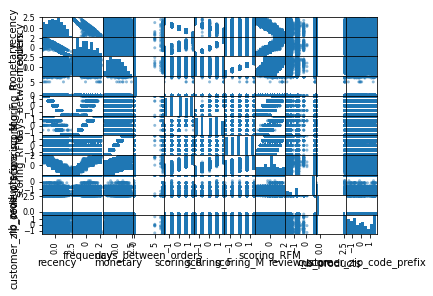

In [13]:
pd.plotting.scatter_matrix(pd.DataFrame(transformed_customers));

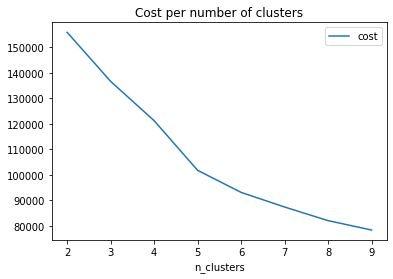

In [15]:
from kmodes.kprototypes import KPrototypes

costs = []

for n_clusters in list(range(2, 10)):
    k_prototypes = KPrototypes(n_clusters=n_clusters, random_state=42, n_jobs=-1)
    k_prototypes.fit_predict(transformed_customers, categorical=[8, 10, 13, 14])
    costs.append({"n_clusters": n_clusters, "cost": k_prototypes.cost_})

pd.DataFrame(costs).plot(title="Cost per number of clusters", x="n_clusters", y="cost");

1    5198
3    4931
0    4498
2    3622
4     373
Name: cluster, dtype: int64


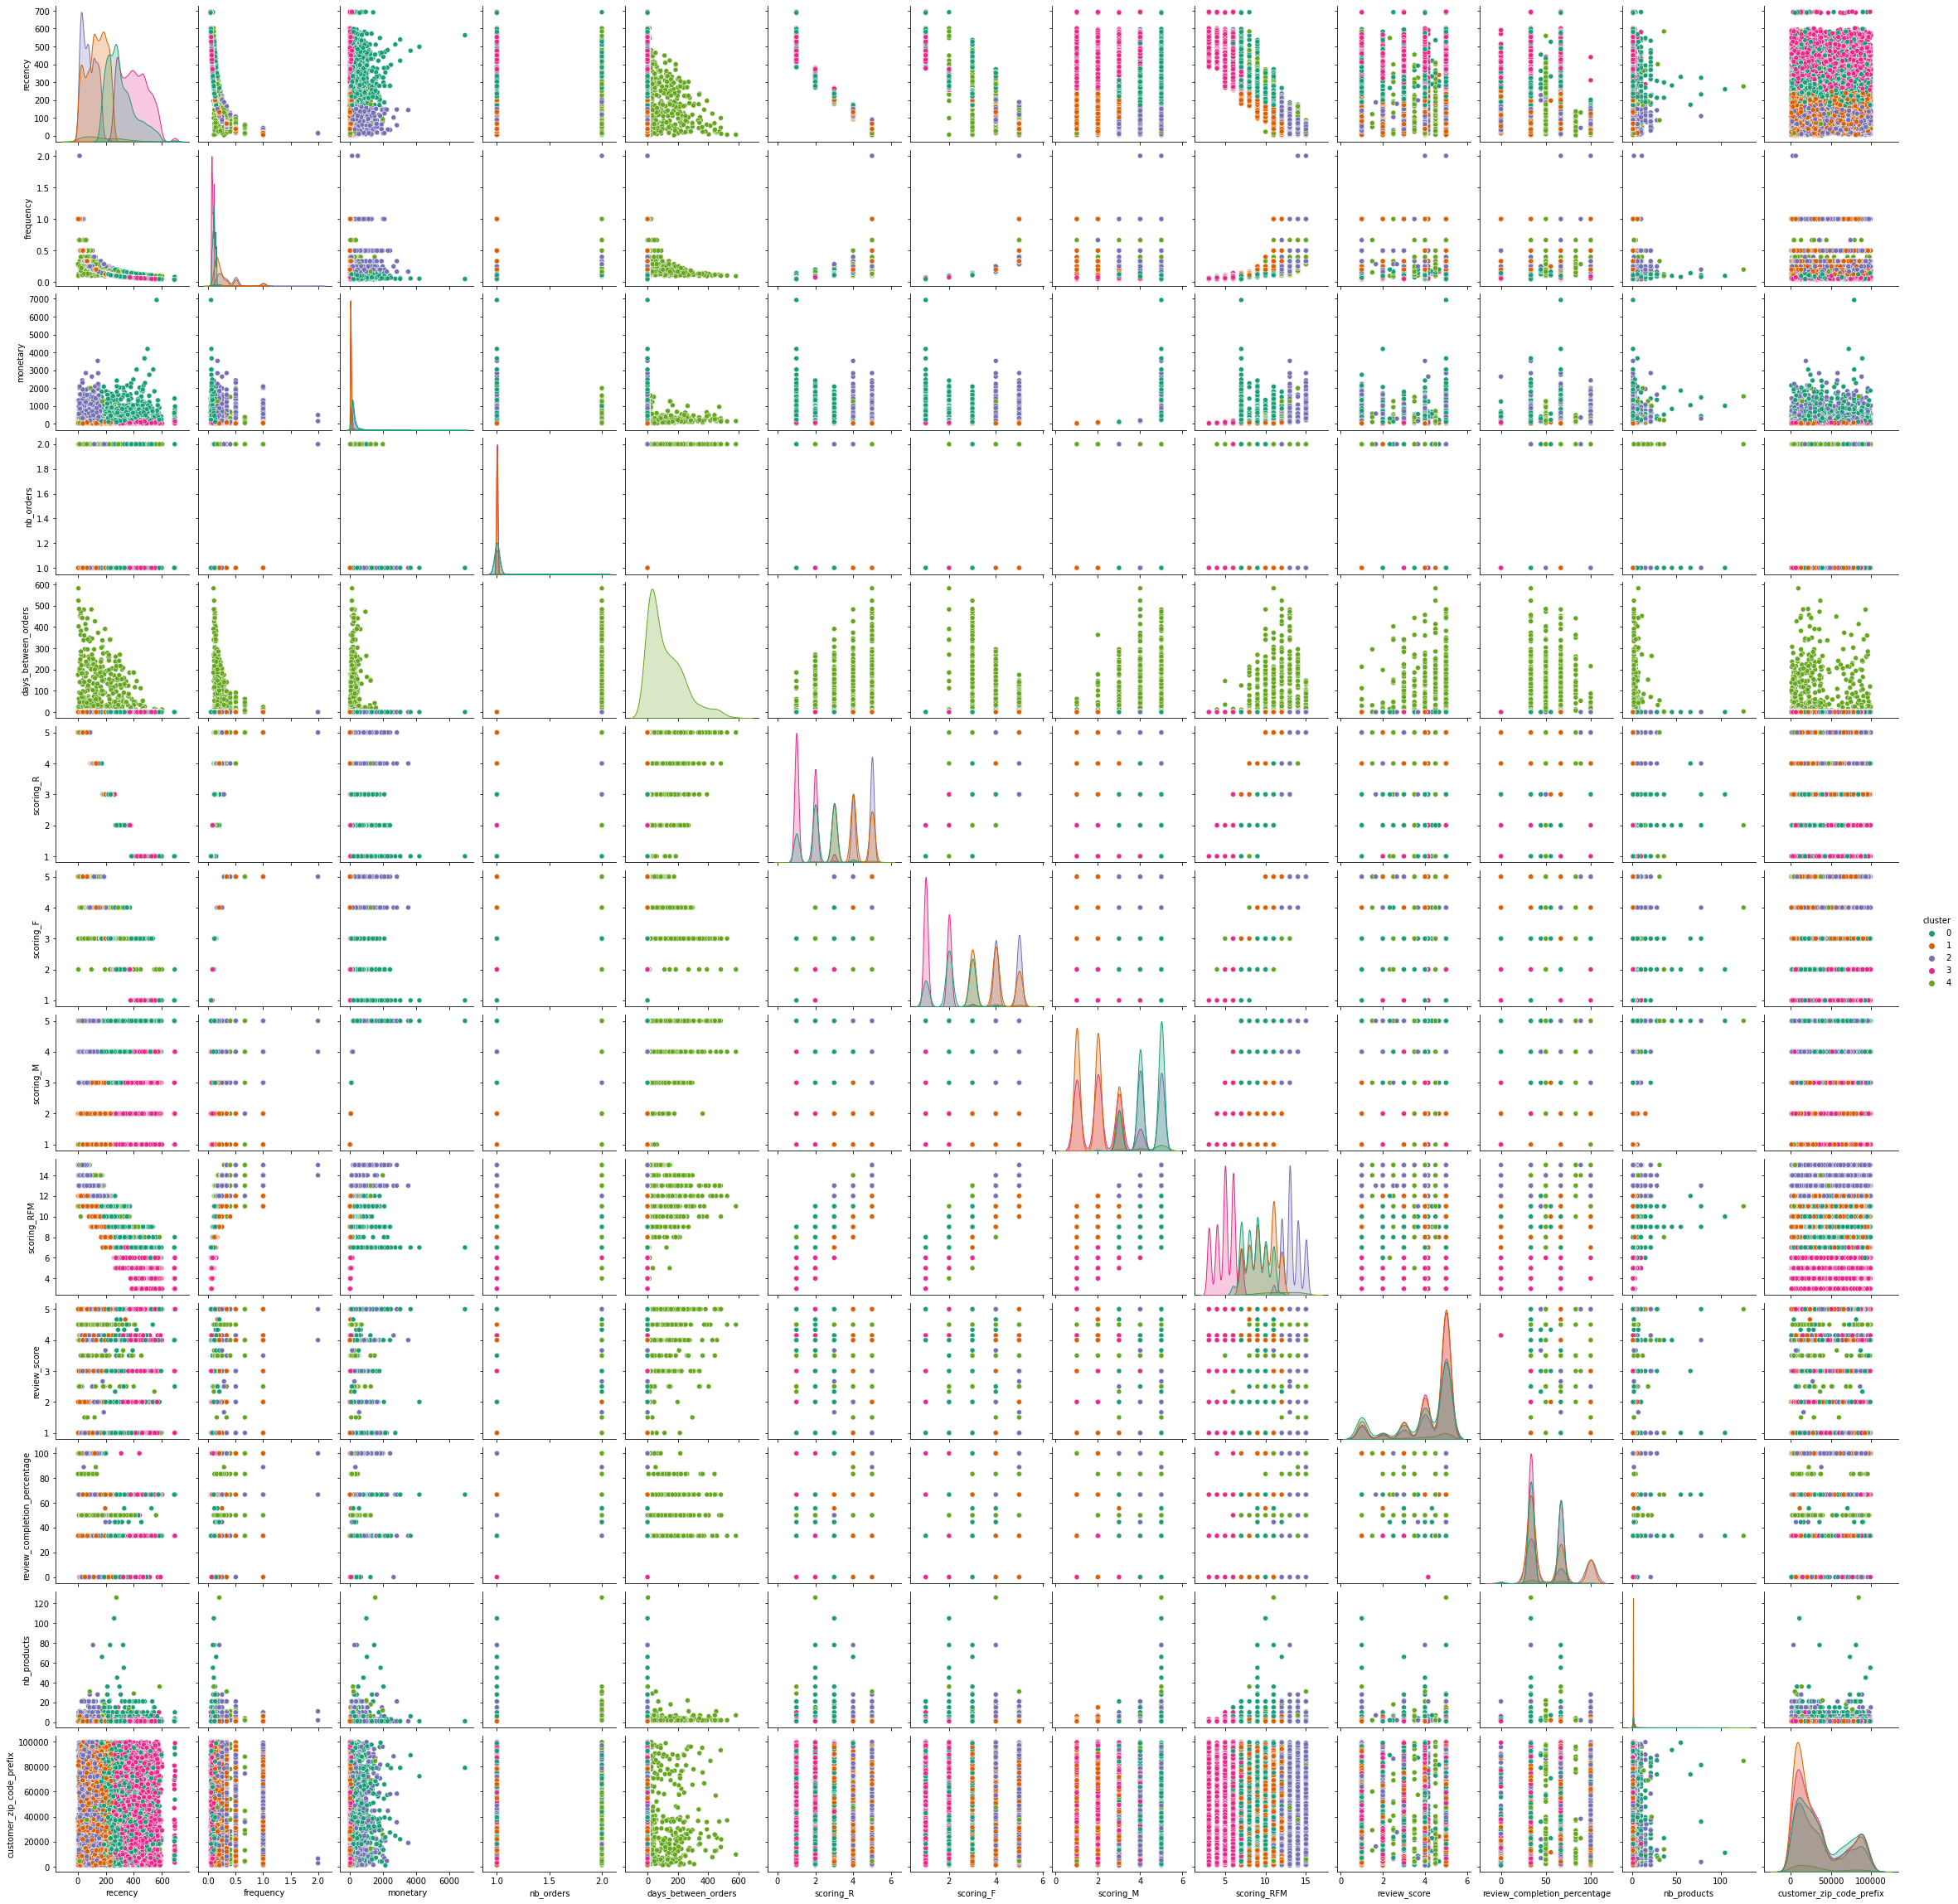

In [16]:
import seaborn as sns
from sklearn import metrics

k_prototypes = KPrototypes(n_clusters=5, random_state=42, n_jobs=-1)

rfmsppl["cluster"] = k_prototypes.fit_predict(
    transformed_customers, categorical=[8, 10, 13, 14]
)
rfmsppl["cluster"] = rfmsppl.cluster.astype("category")

print(rfmsppl["cluster"].value_counts())

sns.pairplot(rfmsppl, hue="cluster", palette="Dark2", diag_kind="kde");

## Clustering visualisation

In [18]:
from sklearn.manifold import TSNE
import plotly.express as px

# Create dummies for categorical variables
df = pd.get_dummies(
    pd.DataFrame(transformed_customers),
    prefix="",
    prefix_sep="",
    columns=transformed_customers.select_dtypes(include=["object", "category"]).columns,
)

print(
    "Silhouette Coefficient: %0.3f" % metrics.silhouette_score(df, rfmsppl["cluster"])
)

tsne = TSNE(n_components=2, learning_rate="auto", init="random", n_jobs=-1)

projected_customers = tsne.fit_transform(df)

fig = px.scatter(
    projected_customers,
    x=0,
    y=1,
    color=rfmsppl.cluster,
    labels={"color": "cluster"},
    opacity=0.8,
)
fig.show()

Silhouette Coefficient: 0.201


In [ ]:
tsne = TSNE(n_components=3, learning_rate="auto", init="random", n_jobs=-1)

projected_customers = tsne.fit_transform(df)

fig = px.scatter_3d(
    projected_customers,
    x=0,
    y=1,
    z=2,
    color=rfmsppl.cluster,
    labels={"color": "cluster"},
    opacity=0.8,
)
fig.show()

In [ ]:
print("END")